# Clustering Group of Machines

### Dataset Used - 
 http://gwa.ewi.tudelft.nl/datasets/gwa-t-13-materna

In [3]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#unzip the data file
!unzip -q '/content/drive/My Drive/GWA-T-13_Materna-Workload-Traces.zip'

In [5]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [6]:
#List of input data folder i.e. Materna-Trace-1, Materna-Trace-2, Materna-Trace-3
Materna_Traces = ['/content/GWA-T-13_Materna-Workload-Traces/Materna-Trace-1', 
        '/content/GWA-T-13_Materna-Workload-Traces/Materna-Trace-2',
        '/content/GWA-T-13_Materna-Workload-Traces/Materna-Trace-3']

In [7]:
#function to read the input data
def readInputData(paths):
  #iterate each data folder
  for path in paths:
    #All csv files in current data folder
    all_files = glob.glob(path + "/*.csv")
    
    data = []
    for filename in all_files:
        #read each csv file
        df = pd.read_csv(filename, delimiter=';', index_col=None, header=0)
        #append the data
        data.append(df)
    #merge the data and make dataframe
    dataframe = pd.concat(data, axis=0, ignore_index=True)
  return dataframe

In [8]:
#call the function
inputData = readInputData(Materna_Traces)

In [9]:
 #first 5 rows of data
 inputData.head()

,Timestamp,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Memory usage [%],Disk read throughput [KB/s],Disk write throughput [KB/s],Disk size [GB],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,04.01.2016 00:00:00,1,0,76,"3,2",2097152,57043,"2,72",0,13,32,0,0
1,04.01.2016 00:05:00,1,0,96,"4,01",2097152,174483,"8,32",0,21,32,0,0
2,04.01.2016 00:10:00,1,0,73,"3,07",2097152,166094,"7,92",8,16,32,0,0
3,04.01.2016 00:15:00,1,0,73,"3,07",2097152,89129,"4,25",0,13,32,0,0
4,04.01.2016 00:20:00,1,0,94,"3,93",2097152,275146,"13,12",0,23,32,1,0


In [10]:
#number of rows and columns in data
inputData.shape
df = inputData

In [11]:
df.describe()

,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
count,5.329730e+06,5.329730e+06,5.329730e+06,5.329730e+06,5.329730e+06,5.329730e+06,5.329730e+06,5.329730e+06,5.329730e+06
mean,2.637684e+00,3.982851e+00,2.596080e+02,8.873539e+06,7.058790e+05,5.352213e+02,1.790060e+02,9.293955e+01,1.396144e+02
std,1.628044e+00,9.022759e+01,6.365165e+02,1.009509e+07,1.135087e+06,6.929329e+03,1.533413e+03,9.121657e+02,1.434829e+03
min,1.000000e+00,0.000000e+00,1.000000e+00,1.048576e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,2.400000e+01,4.194304e+06,8.053100e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,6.900000e+01,8.388608e+06,2.231370e+05,0.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00
75%,4.000000e+00,0.000000e+00,1.840000e+02,1.048576e+07,8.719960e+05,0.000000e+00,3.900000e+01,1.500000e+01,1.700000e+01
max,8.000000e+00,2.048000e+03,1.552800e+04,1.342177e+08,2.365252e+07,3.779170e+05,1.449880e+05,1.126790e+05,1.142190e+05


In [12]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from numpy import unique
from numpy import where

In [13]:
def dbscan(eps, min_samples, data, start, end):
  # define the model
  model = DBSCAN(eps, min_samples)
  # fit model and predict clusters
  yhat = model.fit_predict(data)
  # retrieve unique clusters
  clusters = unique(yhat)
  # create scatter plot for samples from each cluster
  for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(data[row_ix, start], data[row_ix, end])
    plt.title("eps="+str(eps)+"    "+"min_samples="+str(min_samples))
  # show the plot
  plt.show()

In [14]:
df = df.drop('Timestamp', axis=1)
#replace , with . in % values
df = df.replace(to_replace=r',', value='.', regex=True)

# **Analysing specific set of metrics for identifying the best set of features:**



*   CPU usagelog
*   Memory usage [%]
*   Disk read throughput [KB/s]
*   Disk write throughput [KB/s]



In [15]:
data = df[["CPU cores", "CPU capacity provisioned [MHZ]", "CPU usage [MHZ]", 
                  "Memory capacity provisioned [KB]",
                  "Memory usage [KB]", "Disk read throughput [KB/s]",
                  "Disk write throughput [KB/s]", "Disk size [GB]",
                  "Network received throughput [KB/s]",
                  "Network transmitted throughput [KB/s]"]]

In [16]:
machine_data_std = StandardScaler().fit_transform(df)
#randomly choose ten thousand samples
machine_data_index = np.random.randint(1, df.shape[0], 10000)
#Apply DBSCAN algorithm

In [17]:
df['CPU usagelog'] = np.log(df['CPU usage [MHZ]'])

In [18]:
cpu_mem_disk_NW_use_data = df[['CPU usagelog',
                                   'Disk read throughput [KB/s]',
                                   'Disk write throughput [KB/s]']]
#standard scale data                          
cpu_mem_disk_NW_use_data_std = StandardScaler().fit_transform(cpu_mem_disk_NW_use_data)
#randomly choose ten thousand samples
machine_data_index = np.random.randint(1, df.shape[0], 10000)
#Apply DBSCAN algorithm

In [19]:
from sklearn.cluster import OPTICS

# ***IMPLEMENTING OPTICS ALGORITHM***

# OPTICS
Ordering points to identify the clustering structure (OPTICS) is an algorithm for finding density-based clusters in spatial data. Its basic idea is similar to DBSCAN, but it addresses one of DBSCAN's major weaknesses: the problem of detecting meaningful clusters in data of varying density. To do so, the points of the database are (linearly) ordered such that spatially closest points become neighbors in the ordering. Additionally, a special distance is stored for each point that represents the density that must be accepted for a cluster so that both points belong to the same cluster.

In [98]:
def optics_func(data,x,maxeps):
  model = OPTICS(x,maxeps)
  yhat = model.fit_predict(data)
  m = unique(yhat)
  plt.figure(figsize = (8,6))
  for cluster in m:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(data[row_ix, 0], data[row_ix, 1])
    #add title for a plot 
    plt.title("min_sample="+str(int(x*10000))+"    "+"eps = "+str(maxeps))
  # show the plot
  plt.show()

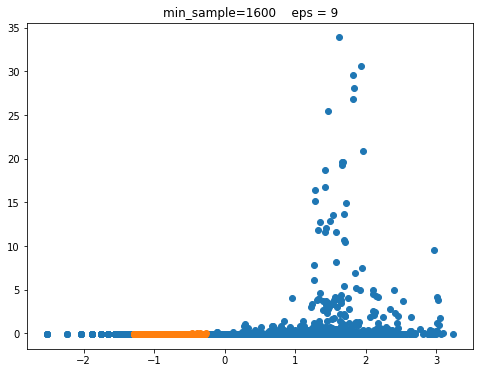

In [99]:
optics_func(cpu_mem_disk_NW_use_data_std[machine_data_index],0.16,9)

# **Hyper Parameter tuning for OPTICS**
In this part I have tuned two parameters of the OPTICS algorithm i.e Minimum samples and maximum distance. That is because OPTICS algorithm works on the concept of density and number of samples and distance between them are the two most important factors for defining the density.
*   **min_samples(x)** = *The number of samples in a neighborhood for a point to be considered as a core point. Also, up and down steep regions can’t have more then min_samples consecutive non-steep points. Expressed as an absolute number or a fraction of the number of samples (rounded to be at least 2).*
*   **max_eps(maxeps)** = *The maximum distance between two samples for one to be considered as in the neighborhood of the other. Default value of np.inf will identify clusters across all scales; reducing max_eps will result in shorter run times.*

In [20]:
def optics(model,data):
  yhat = model.fit_predict(data)
  m = unique(yhat)
  score = metrics.silhouette_score(data, model.labels_, metric='euclidean')
  return score

In [104]:
ca = OPTICS()
param_grid = {"min_samples": [0.25,0.3,0.4,0.5],"max_eps":[8,9,10]}

In [105]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(ca,param_grid,scoring = optics)
search.fit(cpu_mem_disk_NW_use_data_std[machine_data_index])

GridSearchCV(cv=None, error_score=nan,
             estimator=OPTICS(algorithm='auto', cluster_method='xi', eps=None,
                              leaf_size=30, max_eps=inf, metric='minkowski',
                              metric_params=None, min_cluster_size=None,
                              min_samples=5, n_jobs=None, p=2,
                              predecessor_correction=True, xi=0.05),
             iid='deprecated', n_jobs=None,
             param_grid={'max_eps': [8, 9, 10],
                         'min_samples': [0.25, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function optics at 0x7fe62426f620>, verbose=0)

In [106]:
sorted(search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_eps',
 'param_min_samples',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [108]:
k = 0
minsamp = [0 for i in range(12)]
maxeps = [0 for i in range(12)]
result = [0 for i in range(12)]
for i in search.cv_results_['params']:
  minsamp[k] = i.get('min_samples')
  maxeps[k] = i.get('max_eps')
  result[k] = search.cv_results_['mean_test_score'][k]
  k += 1

In [109]:
results = {
    'Min Samples':minsamp,
    'MAX Epsilon':maxeps,
    'Final Score':result
}

In [110]:
df = pd.DataFrame (results, columns = ['Min Samples','MAX Epsilon','Final Score'])

print (df)

    Min Samples  MAX Epsilon  Final Score
0          0.25            8     0.736214
1          0.30            8     0.737316
2          0.40            8     0.930802
3          0.50            8     0.930240
4          0.25            9     0.739852
5          0.30            9     0.740954
6          0.40            9     0.936383
7          0.50            9     0.936383
8          0.25           10     0.740937
9          0.30           10     0.742038
10         0.40           10     0.937468
11         0.50           10     0.937468


# **Conclusion**
**min_samples** = *0.4* and **max_eps** = *10* gave the best results. Hence we can use those parameters for further implementation.

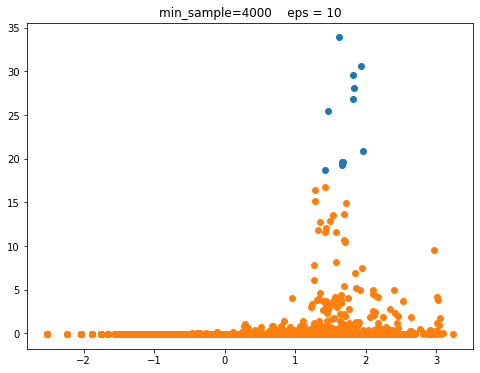

In [111]:
optics_func(cpu_mem_disk_NW_use_data_std[machine_data_index],0.4,10)